## Configuration

In [1]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt


BATCH_SIZE = 256
NUM_WORKERS = 8
CLASSES = [
    'biological',
    'trash',
    'metal',
    'plastic',
    'battery',
    'glass',
    'paper',
    'clothes',
    'cardboard',
    'shoes'
    ]

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset

In [3]:
class GarbageDataset(Dataset):

    def __init__(self, 
                 fg_root: str, 
                 bg_root: str, 
                 classes, 
                 fg_transform=None,
                 transform=None,
                 ):
        self.fg_paths = []
        self.labels = []
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        self.transform = transform
        self.fg_transform = fg_transform

        # Collect all foreground images
        for cls in classes:
            cls_path = os.path.join(fg_root, cls)
            if not os.path.isdir(cls_path):
                continue
            for f in os.listdir(cls_path):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.fg_paths.append(os.path.join(cls_path, f))
                    self.labels.append(self.class_to_idx[cls])

        # Collect backgrounds
        self.bg_paths = [os.path.join(bg_root, f) for f in os.listdir(bg_root)
                         if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        if len(self.bg_paths) == 0:
            raise ValueError("No background images found in " + bg_root)

    def __len__(self):
        return len(self.fg_paths)

    def __getitem__(self, idx):
        fg_path = self.fg_paths[idx]
        label = self.labels[idx]

        # Load foreground
        fg = Image.open(fg_path).convert("RGBA")

        if self.fg_transform:
            fg = self.fg_transform(fg)


        # Random background
        bg_path = random.choice(self.bg_paths)
        bg = Image.open(bg_path).convert("RGBA")
        bg = bg.resize(fg.size)

        # Alpha composite
        composite = Image.alpha_composite(bg, fg)
        # Convert to RGB and tensor
        composite = composite.convert("RGB")

        composite_tensor = self.transform(composite)

        return composite_tensor, label


In [4]:
fg_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(45),
])

transform = models.MobileNet_V3_Large_Weights.IMAGENET1K_V1.transforms()

dataset = GarbageDataset(fg_root='../resources/final_dataset',
                bg_root='../resources/textures',
                classes=CLASSES,
                fg_transform=fg_transform,
                transform=transform
                        )

In [5]:
import numpy as np
class_counts = np.bincount(dataset.labels)
class_counts

array([3217, 3459, 4408, 5545,  944, 8347, 5848, 5327, 5505, 1977])

In [6]:
from torch.utils.data import WeightedRandomSampler
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15], generator=generator)

train_labels = np.array(dataset.labels)[train_dataset.indices]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


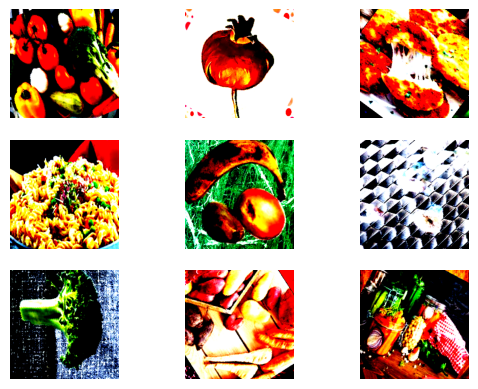

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


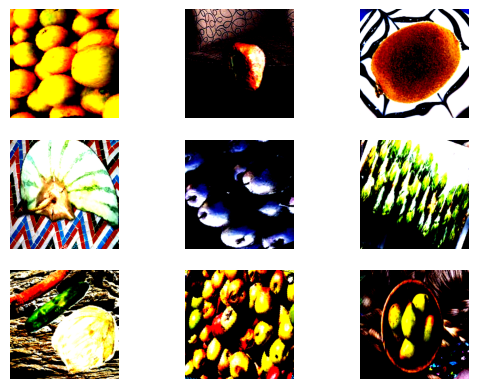

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


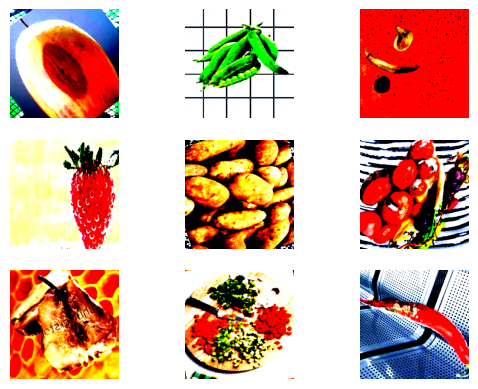

In [7]:
show_dataloader = DataLoader(dataset, batch_size=9, shuffle=False)
iterator = iter(show_dataloader)
for _ in range(3):
    fig, ax = plt.subplots(3, 3)
    batch = next(iterator)
    for i, ax_row in enumerate(ax):
        for j, a in enumerate(ax_row):
            a.imshow(batch[0][i * 3 + j].permute(1, 2, 0))
            a.axis('off')
    plt.show()

## Models

In [8]:
teacher = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
student = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

In [9]:
teacher.fc = nn.Linear(512, len(CLASSES))
student.classifier[3] = nn.Linear(1280, len(CLASSES))

teacher = teacher.to(device)
student = student.to(device)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import math
from datetime import datetime

import numpy as np
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score
)


def train_teacher(model:nn.Module, 
                  train_loader: DataLoader, 
                  val_loader: DataLoader, 
                  model_weights_path: str,
                  epochs=10, 
                  lr=1e-3, 
                  device=device):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best_val = math.inf

    train_losses = []
    val_losses = []
    for epoch in range(epochs):

        # --- training

        model.train()
        running_loss = 0.0
        total = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            
            loop.set_postfix(loss=loss.item())
        
        scheduler.step()
        train_loss = running_loss / total
        
        # --- validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"[Validation]", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        if best_val > val_loss:
            best_val = val_loss
            torch.save(model.state_dict(), f"{model_weights_path}/{model.__class__.__name__}_{datetime.now().strftime("%H:%M:%S")}_epoch{epoch}.pth")
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}| "
                f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
    plt.plot(train_losses, label='training')
    plt.plot(val_losses, label='validation')
    plt.legend()
    plt.show()


import torch
import numpy as np
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def test(model, test_loader, device, num_classes=10):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Accuracy
    accuracy = (all_preds == all_labels).mean() * 100

    # Per-class metrics (vectors of length 10)
    precision_per_class = precision_score(
        all_labels, all_preds, average=None, labels=range(num_classes)
    )
    recall_per_class = recall_score(
        all_labels, all_preds, average=None, labels=range(num_classes)
    )
    f1_per_class = f1_score(
        all_labels, all_preds, average=None, labels=range(num_classes)
    )

    # Balanced (macro) F1 — scalar
    f1_macro = f1_score(
        all_labels, all_preds, average="macro"
    )

    # Confusion matrix: shape (10, 10)
    cm = confusion_matrix(
        all_labels, all_preds, labels=range(num_classes)
    )

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Macro F1: {f1_macro:.4f}")

    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "precision_per_class": precision_per_class,  # (10,)
        "recall_per_class": recall_per_class,        # (10,)
        "f1_per_class": f1_per_class,                # (10,)
        "confusion_matrix": cm                       # (10, 10)
    }


Epoch 1: Train Loss=0.5783| Val Loss=0.8740, Val Acc=0.7510


Epoch 2: Train Loss=0.3133| Val Loss=0.5429, Val Acc=0.8394


Epoch 3: Train Loss=0.2310| Val Loss=0.4510, Val Acc=0.8536


Epoch 4: Train Loss=0.1829| Val Loss=0.3647, Val Acc=0.8904


Epoch 5: Train Loss=0.1382| Val Loss=0.3757, Val Acc=0.8946


Epoch 6: Train Loss=0.1125| Val Loss=0.3129, Val Acc=0.9124


Epoch 7: Train Loss=0.0779| Val Loss=0.2928, Val Acc=0.9224


Epoch 8: Train Loss=0.0624| Val Loss=0.2600, Val Acc=0.9338


Epoch 9: Train Loss=0.0481| Val Loss=0.2382, Val Acc=0.9367


Epoch 10: Train Loss=0.0456| Val Loss=0.2367, Val Acc=0.9412


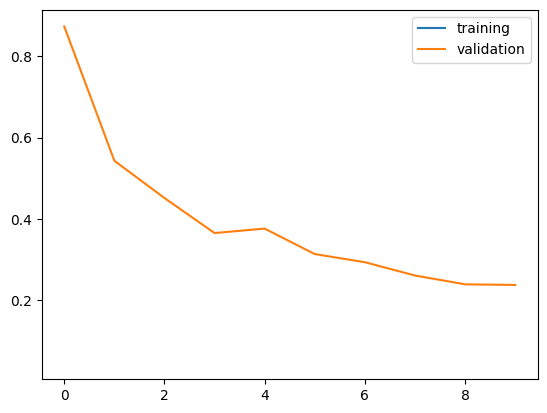

In [11]:
train_teacher(student, 
              train_loader=train_loader,
              val_loader=val_loader,
              model_weights_path='../models/teacher',
              epochs=10)

In [11]:
def train_knowledge_distillation(teacher: nn.Module, 
                                 student: nn.Module, 
                                 train_loader: DataLoader, 
                                 val_loader: DataLoader,
                                 epochs: int, 
                                 learning_rate: float=1e-3, 
                                 temperature: float=2.0, 
                                 soft_target_loss_weight: float=0.25, 
                                 ce_loss_weight: float=0.75,
                                 device=device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(student.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        total = 0

        # --- training

        for inputs, labels in tqdm(train_loader, desc='[Train]', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.shape[0]

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / temperature, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (temperature**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        train_loss = running_loss / total
        
        # --- validation
        student.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"[Validation]", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = student(imgs)
                loss = ce_loss(outputs, labels)
                
                val_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} | "
                f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

In [ ]:
train_knowledge_distillation(
    teacher=teacher,
    student=student,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10)

[Train]:   0%|          | 0/61 [00:00<?, ?it/s]

[Train]:  72%|███████▏  | 44/61 [02:30<00:35,  2.09s/it]

## Model from save

In [20]:
model = models.mobilenet_v3_large()
model.classifier[3] = nn.Linear(1280, len(CLASSES))
model.load_state_dict(torch.load('../models/teacher/MobileNetV3_19:33:42_epoch9.pth', weights_only=True))

<All keys matched successfully>

In [21]:
test(model, test_loader, device)

Test Accuracy: 93.60%
Macro F1: 0.9272


{'accuracy': 93.59952145954837,
 'f1_macro': 0.9271568249622911,
 'precision_per_class': array([0.96344086, 0.8878327 , 0.9341142 , 0.92952612, 0.8707483 ,
        0.97030498, 0.90491803, 0.97733333, 0.93909866, 0.87459807]),
 'recall_per_class': array([0.95116773, 0.85063752, 0.94799406, 0.93635251, 0.8951049 ,
        0.95952381, 0.91089109, 0.9682959 , 0.94601227, 0.92832765]),
 'f1_per_class': array([0.95726496, 0.86883721, 0.94100295, 0.93292683, 0.88275862,
        0.96488428, 0.90789474, 0.97279363, 0.94254279, 0.90066225]),
 'confusion_matrix': array([[ 448,   11,    0,    4,    0,    0,    6,    0,    0,    2],
        [  11,  467,    1,    5,   15,    4,   10,   10,    1,   25],
        [   0,    3,  638,    8,    1,   11,    8,    0,    3,    1],
        [   1,    6,   11,  765,    0,   13,   17,    1,    2,    1],
        [   0,    4,    5,    1,  128,    2,    1,    0,    2,    0],
        [   0,    4,   11,   23,    0, 1209,   10,    0,    2,    1],
        [   3,    7,  

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evaluation_metrics(
    confusion_matrix,
    precision_per_class,
    recall_per_class,
    f1_per_class,
    class_names=None,
    normalize_cm=False
):
    """
    Plots:
    1) Confusion matrix heatmap
    2) Precision / Recall / F1 per class

    Args:
        confusion_matrix (np.ndarray): shape (C, C)
        precision_per_class (np.ndarray): shape (C,)
        recall_per_class (np.ndarray): shape (C,)
        f1_per_class (np.ndarray): shape (C,)
        class_names (list[str], optional): class labels
        normalize_cm (bool): normalize confusion matrix by true class
    """

    num_classes = confusion_matrix.shape[0]

    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]

    # --- Confusion matrix ---
    cm = confusion_matrix.astype(float)
    if normalize_cm:
        cm = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm)

    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Write values in cells
    for i in range(num_classes):
        for j in range(num_classes):
            value = cm[i, j]
            text = f"{value:.2f}" if normalize_cm else f"{int(value)}"
            ax.text(j, i, text, ha="center", va="center")

    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    plt.show()

    # --- Per-class metrics ---
    x = np.arange(num_classes)

    plt.figure(figsize=(10, 5))
    plt.plot(x, precision_per_class, marker="o", label="Precision")
    plt.plot(x, recall_per_class, marker="o", label="Recall")
    plt.plot(x, f1_per_class, marker="o", label="F1-score")

    plt.xticks(x, class_names)
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.title("Per-class Precision, Recall, and F1-score")
    plt.ylim(0.0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Test Accuracy: 93.90%
Macro F1: 0.9301


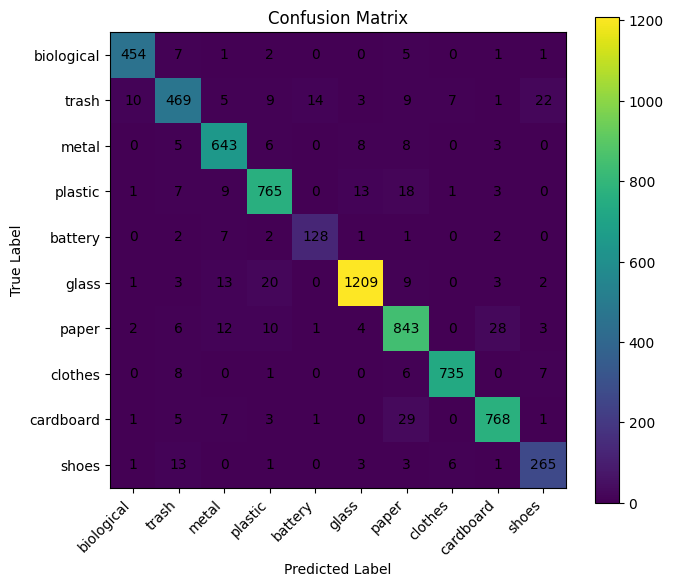

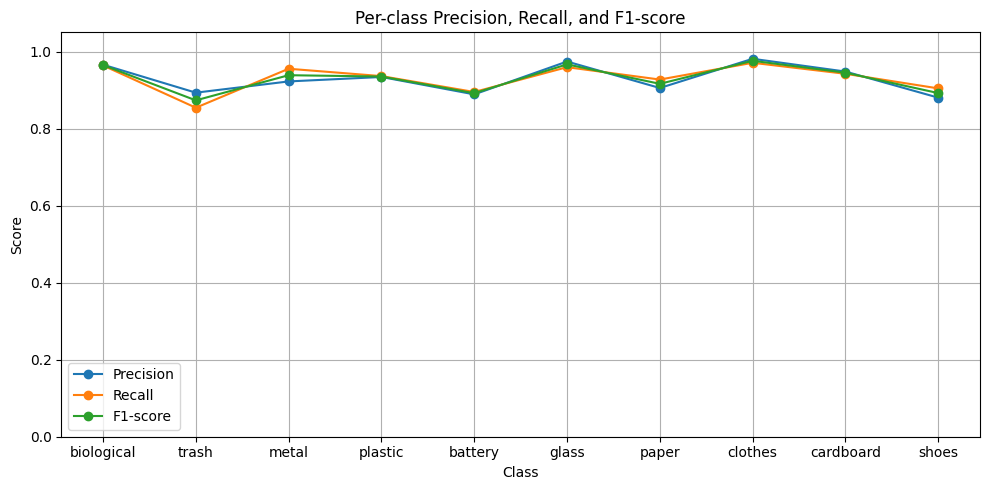

In [23]:
results = test(model, test_loader, device)

plot_evaluation_metrics(
    confusion_matrix=results["confusion_matrix"],
    precision_per_class=results["precision_per_class"],
    recall_per_class=results["recall_per_class"],
    f1_per_class=results["f1_per_class"],
    class_names=CLASSES,
    normalize_cm=False  # set True if you want normalized CM
)
